In [1]:
import numpy as np
#import healpy as hp
from esutil.coords import eq2gal, eq2ec
from astropy.io.fits import getdata
from numpy.lib.recfunctions import append_fields
from dust import getval
from time import time
import ctypes
import emcee_helpers
import emcee
from emcee.interruptible_pool import InterruptiblePool
from multiprocessing import cpu_count
from scipy.stats import norm
from commands import getoutput
from joblib import Parallel, delayed
import cPickle
import gzip
from emcee.utils import MPIPool
import sys
import extcurve_s16
from scipy.optimize import fminbound
import acor
import esutil
from scipy.integrate import quad
import matplotlib.pyplot as plt

/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
work_dir = './'


In [3]:
_lib = ctypes.CDLL('./likelihood_function_quad.so')


In [4]:
nproc = 16


In [5]:
integration_function = _lib.integrate_likelihood


In [6]:
integration_function.argtypes = (ctypes.c_double, ctypes.c_double, ctypes.POINTER(ctypes.c_double), ctypes.c_double)


In [7]:
integration_function.restype = ctypes.c_double


### Calculates the extinction coefficient for all bandpasses using the extinction curve of Schlafly et al. (2016)

In [8]:
def calculate_ext_coeffs(x):
    """Calculates the extinction coefficient for all bandpasses using the extinction curve of Schlafly et al. (2016)"""
    # R(V) = 3.3 + 9.1*x (Section 5.3 of Schlafly et al. 2016)
    # 1-sigma uncertainty in x is 0.02 --> 1-sigma uncertainty in R(V) is 0.18 mag
    bands = ["U", "B", "hipp", "V", "R", "I", "z", "J", "H", "K", "W1", "W2", "W3"]
    band_wavelengths = {"U":0.3663,
                        "B":0.4361,
                        "hipp":0.5170,
                        "V":0.5448,
                        "R":0.6407,
                        "I":0.7980,
                        "z":0.8896,
                        "J":1.22,
                        "H":1.63,
                        "K":2.19,
                        "W1":3.4,
                        "W2":4.6,
                        "W3":12.0
                       }
    ec = extcurve_s16.extcurve(x) # mean extinction curve
    Egr = ec(4876.7) - ec(6200.1)
    return np.array([ec(band_wavelengths[band]*10000.)/Egr for band in bands])


### Calculates the uncertainty in each extinction coefficient given the uncertainty in x parameter (Section 5.3 of Schlafly et al. 2016)

In [9]:
def calculate_unc_in_ext_coeff(Nsamples):
    """Calculates the uncertainty in each extinction coefficient given the uncertainty in x parameter (Section 5.3 of Schlafly et al. 2016)"""
    arr = np.zeros((Nsamples, 13))
    for i, x in enumerate(0.02*np.random.randn(Nsamples)):
        arr[i, :] = calculate_ext_coeffs(x)
    return np.std(arr, ddof=1, axis=0)



### Loading data - Currently using Dambis and Klein & Bloom WISE data with Gaia DR1

### Also define priors here

In [10]:
def load_data(P_ref=0.52854, FeH_ref=-1.4):

    # load Table 2 of Dambis et al. (2013)
    dambis = getdata('Dambis_2013_Table2.fits')

    # load Table 1 of Klein & Bloom (2013)
    tbl = np.genfromtxt(
        'rrl_fit_table1.txt',
        names='name, type, blazhko, period, log10(P_f/P_0), FeH, prior_mu, prior_mu_err, SF_ebv, SF_ebv_err, m_U_obs, m_U_obs_err, m_B_obs, m_B_obs_err, m_hipp_obs, m_hipp_obs_err, m_V_obs, m_V_obs_err, m_R_obs, m_R_obs_err, m_I_obs, m_I_obs_err, m_z_obs, m_z_obs_err, m_J_obs, m_J_obs_err, m_H_obs, m_H_obs_err, m_K_obs, m_K_obs_err, m_W1_obs, m_W1_obs_err, m_W2_obs, m_W2_obs_err, m_W3_obs, m_W3_obs_err, post_mu, post_mu_err',
        dtype='|S10, |S5, bool, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8, f8',
        skip_header=1
    )
    tbl = append_fields(tbl, names=('ra', 'dec', 'gl', 'gb', 'EBV', 'FeHErr', 'par_obs', 'sigma_par'), data=(np.zeros(tbl.size), np.zeros(tbl.size), np.zeros(tbl.size), np.zeros(tbl.size), np.zeros(tbl.size), np.zeros(tbl.size) + 0.15, np.zeros(tbl.size), np.zeros(tbl.size)), usemask=False, asrecarray=False)
    # uncertainty in [Fe/H] is 0.15 dex (Note 8 in Table 1 of Fernley et al. 1998)

    # remove spaces from Table 2 names
    for i, name in enumerate(dambis['Name']):
        dambis['Name'][i] = name.replace(' ', '')
        if dambis['Name'][i][0:2] == 'V0':
            dambis['Name'][i] = name.replace('V0', 'V').replace(' ', '')

    # match Table 2 and Table 1 to get positions of RR Lyrae stars
    for i, name in enumerate(tbl['name']):
        ind = np.where(name == dambis['Name'])[0]
        if ind.size > 0:
            tbl['ra'][i] = dambis['RAJ2000'][ind[0]]
            tbl['dec'][i] = dambis['DEJ2000'][ind[0]]
        else:
            print "Object %s has no data!" % name

    # add galactic coordinates
    gl, gb = eq2gal(tbl['ra'], tbl['dec'])
    tbl['gl'] = gl
    tbl['gb'] = gb

    # add extinction
    tbl['EBV'] = getval(tbl['gl'], tbl['gb'])

    # add TGAS parallaxes
    tgas = np.genfromtxt('tgas_match.txt', names=True)
    # back out TGAS uncertainty corrections
    tgas['parallax_error'] = np.sqrt(tgas['parallax_error']**2 - 0.2**2)/1.4

    h=esutil.htm.HTM(10)
    m1, m2, d12 = h.match(tbl['ra'], tbl['dec'], tgas['ra'], tgas['dec'], 5/3600., maxmatch=1)
    tbl['par_obs'][m1] = tgas['parallax'][m2]/1000.
    tbl['sigma_par'][m1] = tgas['parallax_error'][m2]/1000.
    tbl['ra'][m1] = tgas['ra'][m2]
    tbl['dec'][m1] = tgas['dec'][m2]

    # eliminate objects without TGAS parallaxes
    tbl = tbl[tbl['sigma_par'] <> 0]

    # define the PLRs (Table 2 of Klein & Bloom 2013)
    klein2014_table2 = np.genfromtxt('%s/Klein_et_al_2014_Table2.csv' % work_dir, delimiter=',',names=True, dtype='|S10,f8,f8,f8,f8,f8,f8,f8,f8')

    bands = klein2014_table2['band']
    alphas = klein2014_table2['alpha']
    betas = klein2014_table2['beta']
    gammas = np.array([0.5, 0.4, 0.3, 0.3, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.1, 0.1, 0.1])
    #alphas[9] = -2.326 # K-band slope from Braga et al. (2015)
    alphas[9] = -2.38 # +- 0.04, from Sollima et al. (2006)
    gammas[9] = 0.09 # +- 0.14, from Sollima et al. (2006)
    #ax = (alphas[9]+0.04*np.random.randn(1000))*np.log10(P_ref) + (gammas[9] + 0.14*np.random.randn(1000))*FeH_ref -1.04 + 0.13*np.random.randn(1000)
    betas[9] = -0.50 # np.mean(ax)
    alphas[10] = -2.381 # +- 0.097, from Dambis et al. (2014)
    gammas[10] = 0.106 # +- 0.023, from Dambis et al. (2014)
    #ax = (alphas[10]+0.097*np.random.randn(1000))*np.log10(P_ref) + (gammas[10] + 0.023*np.random.randn(1000))*FeH_ref - 1.135 + 0.077*np.random.randn(1000)
    betas[10] = -0.62
    alphas[11] = -2.269 # +- 0.127, from Dambis et al. (2014)
    gammas[11] = 0.117 # +- 0.023, from Dambis et al. (2014)
    #ax = (alphas[11]+0.127*np.random.randn(1000))*np.log10(P_ref) + (gammas[11] + 0.023*np.random.randn(1000))*FeH_ref - 1.088 + 0.077*np.random.randn(1000)
    betas[11] = -0.62

    # set scatter in all PLRs to 0.001 mag to measure the uncertainty in recovered parameters
    sigma_PLRs = np.zeros(bands.size) + 0.001
    #sigma_PLRs = klein2014_table2['sig_intrinsic']

    #ext_coeffs = np.array([4.334, 3.626, 3.0, 2.742, 2.169, 1.505, 1.263, 0.709, 0.449, 0.302, 0.2, 0.1, 0.05])
    ext_coeffs = calculate_ext_coeffs(0)*0.96710433795664874 # A_band = C_band * E(g-r), following Schlafly et al. (2016); multiply by 0.96710433795664874 to get A_band = C_band * E(B-V)
    # uncertainty in extinction coefficients assuming sigma(x) = 0.02 or sigma(RV) = 0.18 and Schlafly et al. (2016) extinction curve
    ext_coeffs_unc = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.13, 0.12, 0.07, 0.04, 0.03, 0.01, 0.001, 0.05])

    obs_mags = np.zeros((tbl.size, bands.size))
    obs_magErrs = np.zeros((tbl.size, bands.size))

    Nstars = obs_mags.shape[0]
    Nbands = obs_mags.shape[1]

    for b, ext_coeff in enumerate(ext_coeffs):
        obs_mags[:, b] = tbl['m_%s_obs' % bands[b]]
        obs_magErrs[:, b] = tbl['m_%s_obs_err' % bands[b]]

    log10P_fP_0 = tbl['log10P_fP_0']
    EBV = tbl['EBV']

    # RIJHK: Table 2 of Braga et al. (2015)
    # alphas: R = -0.847 +- 0.177, I = -1.137 +- 0.144, J = -1.793 +- 0.109, H = -2.408 +- 0.082, K = -2.326 +- 0.074
    # W1, W2, W3: Eqs. 2-7 of Klein et al. (2014)
    # DM of M4 is 11.4 (Neeley et al. 2015)

    # Gaussian priors on betas, alphas, gammas, and sigma_PLRs from Table 2 of Klein et al. (2013)
    alpha_mean = klein2014_table2['alpha']
    alpha_sig = klein2014_table2['alpha_sig']
    #alpha_mean[9] = -2.326 # from Braga et al. (2015)
    #alpha_sig[9] = 0.074 # from Braga et al. (2015)
    alpha_mean[9] = -2.38 # from Sollima et al. (2006)
    alpha_sig[9] = 0.04 # from Sollima et al. (2006)
    alpha_mean[10] = -2.381 # from Dambis et al. (2014)
    alpha_sig[10] = 0.097 # from Dambis et al. (2014)
    alpha_mean[11] = -2.269 # from Dambis et al. (2014)
    alpha_sig[11] = 0.127 # from Dambis et al. (2014)
    beta_mean = klein2014_table2['beta']
    beta_sig = klein2014_table2['beta_sig']
    beta_mean[9] = -0.50
    beta_sig[9] = 0.23
    beta_mean[10] = -0.62
    beta_sig[10] = 0.09
    beta_mean[11] = -0.62
    beta_sig[11] = 0.09
    gamma_mean = gammas
    gamma_sig = gammas*0 + 0.14
    gamma_mean[10] = 0.106 # from Dambis et al. (2014)
    gamma_sig[10] = 0.023 # from Dambis et al. (2014)
    gamma_mean[11] = 0.117 # from Dambis et al. (2014)
    gamma_sig[11] = 0.023 # from Dambis et al. (2014)
    #sigma_PLR_mean = klein2014_table2['sig_intrinsic']
    #sigma_PLR_sig = klein2014_table2['sig_intrinsic_sig']
    sigma_PLR_mean = np.zeros(bands.size) + 0.001
    sigma_PLR_sig = np.zeros(bands.size) + 0.0001

    # hard limits on PLR parameters, mean +- 7*sigma
    alphas_lower_limit = []
    alphas_upper_limit = []
    for alpha, sig in zip(alpha_mean, alpha_sig):
        alphas_lower_limit.append(alpha - 7*sig)
        alphas_upper_limit.append(alpha + 7*sig)

    alphas_lower_limit = np.array(alphas_lower_limit)
    alphas_upper_limit = np.array(alphas_upper_limit)

    betas_lower_limit = []
    betas_upper_limit = []
    for beta, sig in zip(beta_mean, beta_sig):
        betas_lower_limit.append(beta - 7*sig)
        betas_upper_limit.append(beta + 7*sig)

    betas_lower_limit = np.array(betas_lower_limit)
    betas_upper_limit = np.array(betas_upper_limit)

    # use broad priors for the W1 and W2 bands
    alphas_upper_limit[10:12] = 2
    alphas_lower_limit[10:12] = -5
    betas_upper_limit[10:12] = 0
    betas_lower_limit[10:12] = -4

    # use broad priors for the Hipparcos band
    alphas_upper_limit[2] = 2
    alphas_lower_limit[2] = -5
    betas_upper_limit[2] = 2
    betas_lower_limit[2] = -2

    # this prior is not used right now
    sig_PLR_lower_limit = []
    sig_PLR_upper_limit = []
    for sig_PLR, sig in zip(sigma_PLR_mean, sigma_PLR_sig):
        sig_PLR_lower_limit.append(sig_PLR - 5*sig)
        sig_PLR_upper_limit.append(sig_PLR + 5*sig)

    sig_PLR_lower_limit = np.array(sig_PLR_lower_limit)
    sig_PLR_lower_limit = np.where(sig_PLR_lower_limit <= 0, 0.00001, sig_PLR_lower_limit)
    sig_PLR_upper_limit = np.array(sig_PLR_upper_limit)

    # dump all important data
    dat = {}
    dat['scenario'] = 'real'
    dat['name'] = tbl['name']
    dat['ra'] = tbl['ra']
    dat['dec'] = tbl['dec']
    dat['P_ref'] = P_ref
    dat['type'] = tbl['type']
    dat['blazhko'] = tbl['blazhko']
    dat['FeH_ref'] = FeH_ref
    dat['obs_mags'] = obs_mags
    dat['obs_magErrs'] = obs_magErrs
    dat['par_obs'] = tbl['par_obs']
    dat['sigma_par'] = tbl['sigma_par']
    dat['log10P_fP_0'] = log10P_fP_0
    dat['EBV'] = EBV
    dat['FeH'] = tbl['FeH']
    dat['FeHErr'] = tbl['FeHErr']
    dat['alphas_lower_limit'] = alphas_lower_limit
    dat['alphas_upper_limit'] = alphas_upper_limit
    dat['betas_lower_limit'] = betas_lower_limit
    dat['betas_upper_limit'] = betas_upper_limit
    dat['sig_PLR_lower_limit'] = sig_PLR_lower_limit
    dat['sig_PLR_upper_limit'] = sig_PLR_upper_limit
    dat['alpha_mean'] = alpha_mean
    dat['alpha_sig'] = alpha_sig
    dat['beta_mean'] = beta_mean
    dat['beta_sig'] = beta_sig
    dat['gamma_mean'] = gamma_mean
    dat['gamma_sig'] = gamma_sig
    dat['sigma_PLR_mean'] = sigma_PLR_mean
    dat['sigma_PLR_sig'] = sigma_PLR_sig
    dat['ext_coeffs'] = ext_coeffs
    dat['ext_coeffs_unc'] = ext_coeffs_unc
    with gzip.open('TGAS_data.pklz', 'wb') as f:
        cPickle.dump(dat, f)

    return dat


### Calculate log likelihood

In [11]:
def lnprob(theta, dat, bands_to_process=[11], rel_tolerance=1e-09, FeH_ref=-1.4, P_ref=0.52854):
    Nbands = len(bands_to_process)
    betas = theta[0:Nbands]
    alphas = theta[Nbands:2*Nbands]
    ln_gammas = theta[2*Nbands:3*Nbands]
    ln_sigma_PLRs = theta[3*Nbands:4*Nbands]
    ln_f_par = theta[4*Nbands]
    par_offset = theta[4*Nbands + 1]
    ln_sigma_par_sys = theta[4*Nbands + 2]
    ln_scale_length = theta[4*Nbands + 3]
    if (any(alphas < dat['alphas_lower_limit'][bands_to_process]) | any(alphas > dat['alphas_upper_limit'][bands_to_process]) |
        any(betas < dat['betas_lower_limit'][bands_to_process]) | any(betas > dat['betas_upper_limit'][bands_to_process]) |
        any(ln_gammas < -7) | any(ln_gammas > 0) | any(ln_sigma_PLRs < -7) | any(ln_sigma_PLRs > -0.7) |
        (ln_f_par < -7) | (ln_f_par > 2) |
        (np.abs(par_offset) > 0.002) |
        (ln_sigma_par_sys < np.log(0.001/1000.)) | (ln_sigma_par_sys > np.log(2./1000.)) |
        (ln_scale_length < np.log(50)) | (ln_scale_length > np.log(5000))
       ):
        return -np.inf
    gammas = np.exp(ln_gammas)
    sigma_PLRs = np.exp(ln_sigma_PLRs)
    f_par = np.exp(ln_f_par)
    sigma_par_sys = np.exp(ln_sigma_par_sys)
    scale_length = np.exp(ln_scale_length)
    lnL = 0
    # loop over bands
    for b, band in enumerate(bands_to_process):
        # calculate the likelihood for a single star
        for star in np.where(np.isfinite(dat['obs_mags'][:, band]))[0]:
            # variance in the corrected parallax
            var_par = (f_par*dat['sigma_par'][star])**2 + sigma_par_sys**2
            # predicted absolute magnitude of this star assuming some PLZ parameters for this band
            Mpred = betas[b] + alphas[b]*dat['log10P_fP_0'][star] + gammas[b]*(dat['FeH'][star] - FeH_ref)
            # variance in the predicted absolute magnitude
            var_Mpred = (gammas[b]*dat['FeHErr'][star])**2 + (alphas[b]*0.02*dat['log10P_fP_0'][star])**2
            # dereddened magnitude
            mag_dereddened = dat['obs_mags'][star, band] - dat['ext_coeffs'][band]*dat['EBV'][star]
            # variance in the dereddened magnitude
            var_mag = dat['obs_magErrs'][star, band]**2 + (dat['ext_coeffs'][band]*(dat['ext_coeffs_unc'][band]+0.1)*dat['EBV'][star])**2 + sigma_PLRs[b]**2
            # "observed/predicted" distance modulus
            DM = mag_dereddened - Mpred
            # variance in DM
            var_DM = var_mag + var_Mpred
            # find the MAP distance
            distance_limits = (200., 2700.)
            # determine optimal integration limits for distance d
            d_MAP = 10*10**(0.2*(mag_dereddened - Mpred))
            d_min = 10*10**(0.2*(5*np.log10(d_MAP) - 5 - np.sqrt(var_mag)))
            d_max = 10*10**(0.2*(5*np.log10(d_MAP) - 5 + np.sqrt(var_mag)))
            sigma_d = np.max([d_MAP-d_min, d_max-d_MAP])
            d_min = np.max([distance_limits[0], d_MAP - 5*sigma_d])
            d_max = np.min([distance_limits[1], d_MAP + 5*sigma_d])
            integral = integration_function(ctypes.c_double(d_min), ctypes.c_double(d_max), (ctypes.c_double*6)(*[dat['par_obs'][star], var_par, DM, var_DM, par_offset, scale_length]), ctypes.c_double(rel_tolerance))
            # likelihood for this star and band
            integrated_likelihood = 1./np.sqrt((2*np.pi)**2*var_par*var_DM) * 1./(2*scale_length**3) * integral
            if integrated_likelihood > 0:
                lnL += np.log(integrated_likelihood)
            else:
                lnL += (-200)
    lnprior = np.sum(np.log(gammas) + np.log(f_par))# + norm.logpdf(alphas, loc=-2.25, scale=0.01))
    return lnL + lnprior - 20000


### Run emcee 

In [12]:
def run_emcee(dat, bands_to_process=[11], rel_tolerance=1e-09, debug=True):

    Nbands = len(bands_to_process)

    ndim = 4*Nbands + 4 # number of parameters in the model
    nwalkers = 160 # number of MCMC walkers
    nburn = 1000 # ignore this number of steps at the beginning
    nsteps = 2500

    theta0 = np.array(list(dat['beta_mean'][bands_to_process]) + list(dat['alpha_mean'][bands_to_process]) + list(np.log(dat['gamma_mean'][bands_to_process])) + list(np.log(dat['sigma_PLR_mean'][bands_to_process])) + [np.log(1.0)] + [0.0/1000.] + [np.log(0.17/1000.)] + [np.log(500.)])

    # use Gaussian widths of priors to generate initial guesses for slope, intercept and sigma
    starting_guesses = np.random.normal(theta0, [beta for beta in dat['beta_sig'][bands_to_process]]+[alpha for alpha in dat['alpha_sig'][bands_to_process]]+[gamma for gamma in dat['gamma_sig'][bands_to_process]]+[sig for sig in dat['sigma_PLR_sig'][bands_to_process]]+[0.2]+[0.1/1000.]+[0.2]+[0.2], (nwalkers, ndim))

    # clip the guesses to appropriate ranges
    starting_guesses = np.clip(starting_guesses, list(dat['betas_lower_limit'][bands_to_process])+list(dat['alphas_lower_limit'][bands_to_process])+list(np.zeros(Nbands)-7)+list(np.zeros(Nbands)-7)+[-7]+[-2./1000]+[np.log(0.001/1000.)]+[np.log(50)], list(dat['betas_upper_limit'][bands_to_process])+list(dat['alphas_upper_limit'][bands_to_process])+list(np.zeros(Nbands))+list(np.zeros(Nbands)-0.7)+[2]+[2./1000]+[np.log(2/1000.)]+[np.log(5000)])

    # limit the sample to some subsample
    good = np.abs(dat['sigma_par']/dat['par_obs']) < 10
    #good = dat['FeH'] > -2.0
    good = dat['type'] == 'RRab'
    print '%d stars in the sample.' % np.where(good)[0].size

    dat_good = dat.copy()
    dat_good['log10P_fP_0'] = dat_good['log10P_fP_0'][good]
    dat_good['par_obs'] = dat_good['par_obs'][good]
    dat_good['sigma_par'] = dat_good['sigma_par'][good]
    dat_good['obs_mags'] = dat_good['obs_mags'][good, :]
    dat_good['obs_magErrs'] = dat_good['obs_magErrs'][good, :]
    dat_good['FeH'] = dat_good['FeH'][good]
    dat_good['FeHErr'] = dat_good['FeHErr'][good]
    dat_good['EBV'] = dat_good['EBV'][good]

    # check that we are not getting -np.inf for starting guesses
    if debug:
        print "Log-likelihood for the initial guess = %.2f" % lnprob(theta0, dat_good, bands_to_process=bands_to_process, rel_tolerance=rel_tolerance)
    with Parallel(n_jobs=nproc) as parallel:
        lnP = parallel(delayed(lnprob)(p, dat_good, bands_to_process=bands_to_process, rel_tolerance=rel_tolerance) for p in starting_guesses)
    bad = np.where(~np.isfinite(lnP))[0]
    if (bad.size > 0):
        starting_guesses[bad] = theta0
        if debug:
            print "Warning: Fixed %d bad initial guesses" % bad.size

    pool = InterruptiblePool(processes=nproc)

    # initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool, args=[dat_good], kwargs={'rel_tolerance':rel_tolerance, 'bands_to_process':bands_to_process})

    # run the chains
    scenario = dat['scenario']
    pos, prob, state = emcee_helpers.run_mcmc_with_pbar(sampler, starting_guesses, nsteps)
    
    pool.terminate()
    
    #emcee_helpers.emcee_plots(lnp_fn, sampler, theta0=theta0, figout=None, plt=None,
                #marginalized=True, triangle=True, chains=True)

    # check acceptance fraction and measure autocorrelation time
    if debug:
        print
        print
        print 'Minimum, mean, and maximum acceptance fraction: %.2f, %.2f, %.2f' % (np.min(sampler.acceptance_fraction), np.mean(sampler.acceptance_fraction), np.max(sampler.acceptance_fraction))
        acors = []
        for param in np.arange(ndim):
            acors.append(acor.acor(np.mean(sampler.chain, axis=0)[:, param])[0])
        acors = np.array(acors)
        print "Maximum autocorrelation time is %.2f" % acors.max()

    # check that the chains have converged
    med = np.median(sampler._lnprob[:, -1])
    rms = 0.741*(np.percentile(sampler._lnprob[:, -1], 75) - np.percentile(sampler._lnprob[:, -1], 25))
    if debug:
        plt.figure(1)
        plt.clf()
        plt.imshow(sampler.lnprobability, aspect=(1.*nsteps/nwalkers), vmin=np.percentile(sampler.lnprobability[:, -1], 5))
        plt.xlabel('step')
        plt.ylabel('walker')
        plt.colorbar()
        plt.savefig('%s/lnProb_walkers_%s_%.0e.png' % (work_dir, scenario, rel_tolerance))

    # determine nburn by checking the convergence of chains
    if debug:
        param_num = -1
        plt.clf()
        plt.plot(sampler.chain[:, :, param_num].T)
        plt.plot(np.median(sampler.chain[:, :, param_num].T, axis=1), 'k-', lw=3)
        plt.xlabel("step")
        plt.ylabel('Parameter %d' % param_num)
        plt.savefig('%s/chains_%s_%.0e.png' % (work_dir, scenario, rel_tolerance))

    # dump burned chains
    bands = np.array(["U", "B", "hipp", "V", "R", "I", "z", "J", "H", "K", "W1", "W2", "W3"])[bands_to_process]

    # exponentiate some parameters
    for b, band in enumerate(bands):
        sampler.chain[:, :, b*4 + 2] = np.exp(sampler.chain[:, :, b*4 + 2])
        sampler.chain[:, :, b*4 + 3] = np.exp(sampler.chain[:, :, b*4 + 3])

    sampler.chain[:, :, -1] = np.exp(sampler.chain[:, :, -1])
    sampler.chain[:, :, -2] = np.exp(sampler.chain[:, :, -2])
    sampler.chain[:, :, -4] = np.exp(sampler.chain[:, :, -4])

    param_list = ''
    for param in ['beta', 'alpha', 'gamma', 'sigma']:
        for band in bands:
            param_list = param_list + param+'_'+band+','

    param_list = param_list + 'f_par,par_offset,sigma_par_sys,scale_len'

    # dump final chains
    sampler = emcee_helpers.SamplerData(sampler, theta0)
    sampler.attrs['theta_names'] = param_list.split(',')
    sampler.writeto('%s/PLR_fit_%s_%.0e.h5' % (work_dir, scenario, rel_tolerance))

    # eliminate bad chains using logprob
    good_chains = sampler.lnprobability[:, -1] > np.percentile(sampler.lnprobability[:, -1], 5)
    if debug:
        print "%d good chains (out of %d)." % (np.where(good_chains)[0].size, nwalkers)

    # use only good chains for parameter statistics
    if debug:
        sampler.chain = sampler.chain[good_chains, nburn:, :]
        sampler.lnprobability = sampler.lnprobability[good_chains, nburn:]
        # most probable values
        print
        print
        print "Most probable values:"
        max_prob = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
        for i, par in enumerate(sampler.attrs['theta_names']):
            print '%s = %.5f' % (par, max_prob[i])
        print "------------------"

        # median, 16th and 84th percentile (1-sigma)
        print
        print "Median, 16th and 84th percentile (1-sigma):"
        stats = np.percentile(sampler.flatchain, [16, 50, 84], axis=0)
        for i, par in enumerate(sampler.attrs['theta_names']):
            print '%s = %.5f  %.5f + %.5f' % (par, stats[1][i],
                                              stats[0][i] - stats[1][i],
                                              stats[2][i] - stats[1][i]
                                             )

    return sampler


In [14]:
dat = load_data()


107 stars in the sample.
Log-likelihood for the initial guess = -19456.44
|##########| 2500/2500 100% [time: 08:03, eta: 00:00,  5.17 iters/sec]        

Minimum, mean, and maximum acceptance fraction: 0.30, 0.40, 0.44
Maximum autocorrelation time is 131.25
152 good chains (out of 160).


Most probable values:
beta_W1 = -0.46297
alpha_W1 = -2.16552
gamma_W1 = 0.18101
sigma_W1 = 0.04524
f_par = 0.82249
par_offset = -0.00003
sigma_par_sys = 0.00016
scale_len = 407.21740
------------------

Median, 16th and 84th percentile (1-sigma):
beta_W1 = -0.41912  -0.10261 + 0.11408
alpha_W1 = -2.48637  -0.74529 + 0.77391
gamma_W1 = 0.14732  -0.08679 + 0.09028
sigma_W1 = 0.06322  -0.04288 + 0.08339
f_par = 0.86270  -0.32086 + 0.30902
par_offset = -0.00005  -0.00005 + 0.00005
sigma_par_sys = 0.00016  -0.00005 + 0.00003
scale_len = 402.17212  -29.76842 + 31.82778


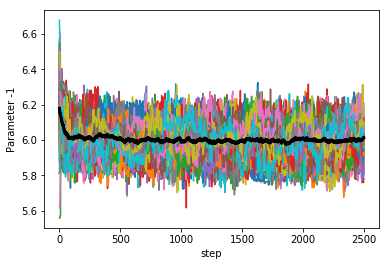

In [15]:
sampler = run_emcee(dat, bands_to_process=[10])

# TO DO:

## Priors:

Want to adapt the priors on the PL relations as follows:

* PL slopes ($\alpha$) should get steeper with increasing wavelength (i.e. become increasingly negative).

* PL zero-points ($\beta$) should get brighter with increasing wavelength (i.e. become increasingly negative).

* PL dispersion ($\sigma_{PLR_sig}$) should get smaller with increasing wavelength. Not sure right now if this should be a hard limit, or how much leeway this should have as it's data-quality dependent.

* Keep all initital guesses that come from the literature.

* Not sure right now what to do about metallicity coefficient ($\gamma$). In theory should decrease with increasing wavelength, but don't want to force that until tested. Impliment the other priors then test.

## Plots:

* Work out how to turn on the diagnostic plots available in emcee_helpers

## h5py:

* How the fuck do you read the .h5 input back in sensibly????



## edited emcee_helpers to turn on plotting?

Changed definition of emcee_plots to figout=True

In [17]:
reload(emcee_helpers)

<module 'emcee_helpers' from 'emcee_helpers.py'>

107 stars in the sample.
Log-likelihood for the initial guess = -19456.44
|##########| 2500/2500 100% [time: 07:25, eta: 00:00,  5.61 iters/sec]        

Minimum, mean, and maximum acceptance fraction: 0.28, 0.39, 0.43
Maximum autocorrelation time is 126.17
152 good chains (out of 160).


Most probable values:
beta_W1 = -0.44611
alpha_W1 = -2.42191
gamma_W1 = 0.19437
sigma_W1 = 0.06350
f_par = 0.83225
par_offset = -0.00004
sigma_par_sys = 0.00015
scale_len = 407.70640
------------------

Median, 16th and 84th percentile (1-sigma):
beta_W1 = -0.41743  -0.10665 + 0.11543
alpha_W1 = -2.49227  -0.74133 + 0.75729
gamma_W1 = 0.14942  -0.08306 + 0.08849
sigma_W1 = 0.06511  -0.04422 + 0.08707
f_par = 0.86342  -0.31745 + 0.33998
par_offset = -0.00005  -0.00006 + 0.00005
sigma_par_sys = 0.00016  -0.00006 + 0.00003
scale_len = 401.57171  -29.95768 + 31.81215


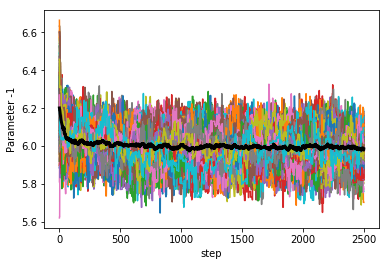

In [18]:
sampler = run_emcee(dat, bands_to_process=[10])